# Analyzing Akshay Pawar’s “ROC_AUC & Decision Boundary for Titanic survival” Version 11 for Titanic - Machine Learning from Disaster Competition on Kaggle

**Authors: Jaimie Chin**

The purpose of Akshay Pawar’s ADS is to acquire stable results on predicting Titanic disaster outcome (which passengers would survive). Pawar’s goal is to tune classification models based on ROC and AUC scores to achieve the best stability/accuracy and choose the most consistent predictions under a Voting Classifier. In other words, this ADS values accuracy and consistency by choosing the best attributes to predict survival and choosing the most consistent prediction among all the most accurate classification models.

* You can find Pawar's ADS submission on Kaggle [here](https://www.kaggle.com/code/akshaypawar7/roc-auc-decision-boundary-for-titanic-survival).

* You can find the *Titanic - Machine Learning from Disaster Competition* on Kaggle [here](https://www.kaggle.com/c/titanic).

## Goal with this Analysis

As Pawar’s ADS values accuracy and consistency with its predictions, there is a trade-off that may be observed with predictive fairness. Pawar’s ADS should be evaluated for disparate impact and/or disparate treatment of individuals based on the protected characteristics: sex, age, ticket class. We should observe if/how individuals are treated differently within such groups. We may also want to observe trade-offs regarding the privacy of passenger data because the ADS does not have any function to mitigate sensitive information that can be used to identify passengers.


### Setup

Install appropriate packages for analysis 

In [ ]:
!pip install aif360==0.3.0 
!pip install aif360[LFR]
!pip install -q kaggle

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from google.colab import files

from scipy.stats import entropy, ks_2samp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.spatial.distance import euclidean

from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import sys
import warnings

import json
import time 
from tqdm import tqdm

# Import ML models that Pawar uses for his final Voting Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import mutual_info_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate, GridSearchCV, KFold, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

pip install 'aif360[LFR]'


### Import .csv files from Kaggle 

Please follow the commented directions on how to import Kaggle competition .csv files into Colaboratory. *You will need a Kaggle.com account to do this.* More details directions can be found [here](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/#:~:text=Fire%20up%20a%20Google%20Colab,you%20just%20downloaded%20from%20Kaggle.&text=Now%20you%20are%20all%20set,need%20to%20load%20the%20dataset.).

If you are unable to successfully connect to Kaggle using the provided code, please manually download train and test files from the Kaggle competition, upload to Colaboratory and run the cell that reads the .csv files (skip the next 3 cells)

In [ ]:
# Import the "kaggle.json" file from Kaggle account to directly download .csv files from Competitions 
# Go to 'Account' on Kaggle.com and click "Create New API Token"
# "kaggle.json" will download on to your computer 
# Upload "kaggle.json" file to Google Colaboratory from the "Choose Files" prompt 

# If you face an errors, try: "Expire All API Tokens" when you Go to 'Account' on Kaggle.com
# Create a new API token and try again
# Please make sure your file is named "kaggle.json" and not "kaggle.json (1)" or any other file name

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaimiechin","key":"75d4e7d3ecd1f2896abf518660edf85f"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            917        642  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1000        592  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           3557         85  1.0              


In [ ]:
!kaggle competitions download -c titanic
!mkdir titanic
!unzip titanic.zip -d titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘titanic’: File exists
Archive:  titanic.zip
replace titanic/gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: titanic/gender_submission.csv  
replace titanic/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: titanic/test.csv        
replace titanic/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: titanic/train.csv       


In [ ]:
# Read the .csv files 
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# display train data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Display the test data 
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


It seems like the provided "test.csv" file from the competition does not have the true values for "Survived" (our target attribute). As you will see later, as we recreate Pawar's ADS, he imputes the values of "Survived" for the "test" dataframe and uses those imputed values to test his ADS. 

For our analysis purposes, we decided to split the provided train.csv into "train" and "test" dataframes so we have "true values" of survived. We will still use Pawar's imputed values for the "Age" column however as that is an attribute we wish to analyze further. 



In [ ]:
# Pawar merges train and test datasets for visualizations
# We will use the merged dataframe for our own visualizations as well

train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

df = pd.concat([train, test]).reset_index(drop=True)

#Visualizations & Data Exploration


## Attribute Information & Null-values


In [ ]:
# Attribute information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


From this information, we may need to recode values for fairness analysis, namely "Sex", "Age", "Fare" and "PClass"

In [ ]:
# Number of missing data within each attribute 	
df.isna().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

We can also see here that the test.csv does not provide true values for "Survived" given the 418 missing values. 

It is unfortunate that "Age" has so many missing values since it is one attribute of interest for our analysis. Pawar imputes the missing values for this attribute, so we will use the same imputations for our analysis.

In [ ]:
# Remapping attributes for visualizations
# We decided to use the same labels as Pawar to make sure our visualizations are replicable and accurate

a = train[['Survived', 'Sex', 'Pclass', 'SibSp', 'Age']].dropna()
a['Pclass']= a['Pclass'].map({1:'1 Pclass',2:'2 Pclass',3:'3 Pclass'})
a['Survived'] = a['Survived'].map({1:'Survived',0: 'Not Survived'})
a['SibSp']= a['SibSp'].map(lambda x: str(x)+' SibSp')

## Distributions of each Attribute


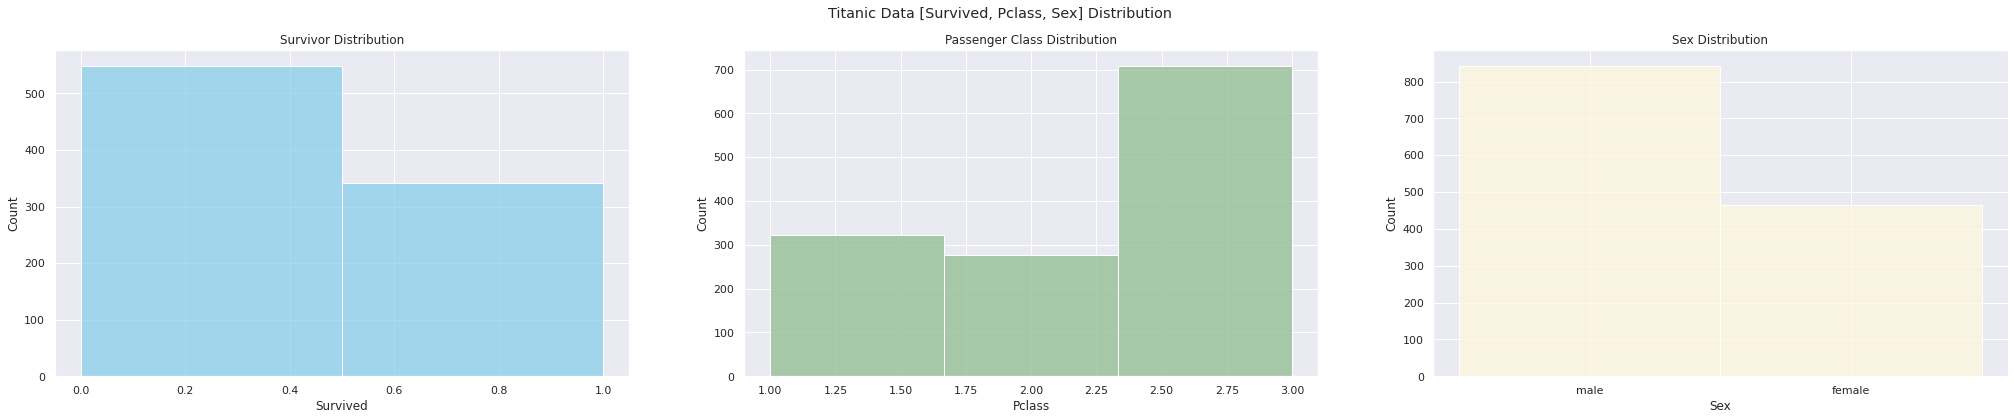

In [ ]:
# Histogram plot categorical attributes of interest

sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(35, 6))

fig.suptitle('Titanic Data [Survived, Pclass, Sex] Distribution')

sns.histplot(data=df, x="Survived", color="skyblue", bins=2, ax=axs[0])
axs[0].set_title('Survivor Distribution')

sns.histplot(data=df, x="Pclass", color="darkseagreen", bins=3, ax=axs[1])
axs[1].set_title('Passenger Class Distribution')

sns.histplot(data=df, x="Sex", color="cornsilk", ax=axs[2])
axs[2].set_title('Sex Distribution')

plt.show()

It appears here that there were almost twice as many people who did not survivde, who were in the 3rd Passenger class and who were male. These may tell us more information about what we choose to be our protected atrributes, privileged groups and unprivileged groups

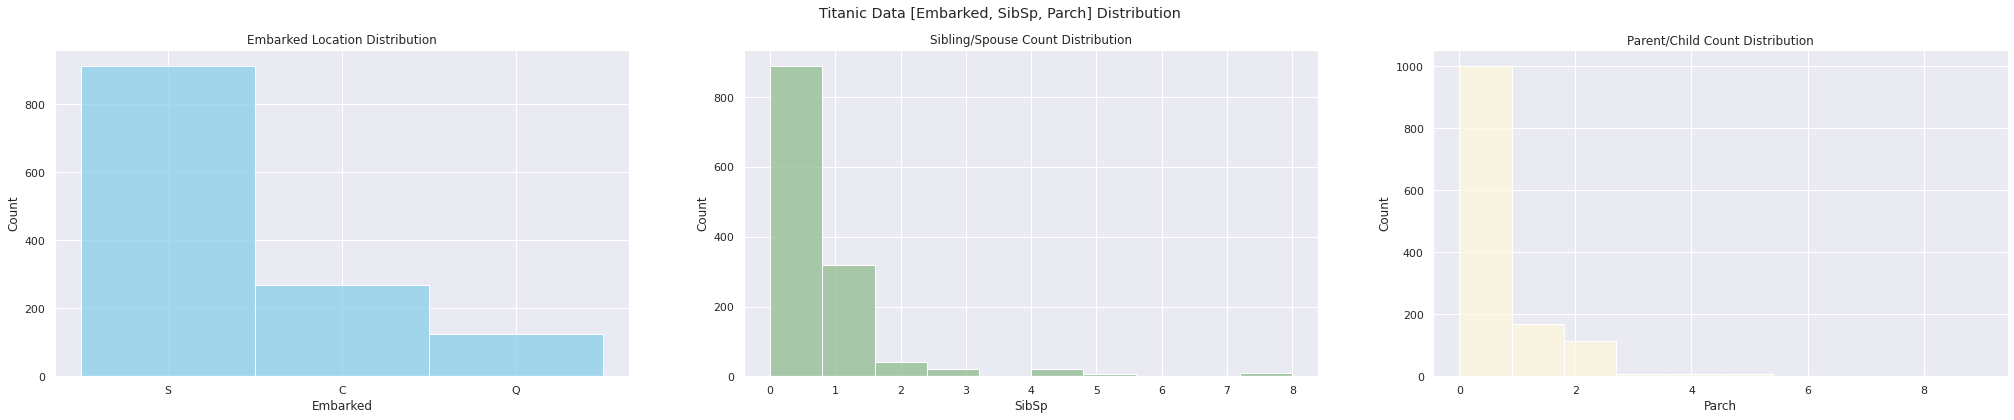

In [ ]:
# Histogram plot categorical attributes of interest

fig, axs = plt.subplots(1, 3, figsize=(35, 6))

fig.suptitle('Titanic Data [Embarked, SibSp, Parch] Distribution')

sns.histplot(data=df, x="Embarked", color="skyblue", ax=axs[0])
axs[0].set_title('Embarked Location Distribution')

sns.histplot(data=df, x="SibSp", color="darkseagreen", bins=10, ax=axs[1])
axs[1].set_title('Sibling/Spouse Count Distribution')

sns.histplot(data=df, x="Parch", color="cornsilk", bins=10, ax=axs[2])
axs[2].set_title('Parent/Child Count Distribution')

plt.show()

These categorical values are skewed far to the right. We're not sure if we want to use these for our fairnss analysis given the number of null values and lack of relevance in contributing to survival.

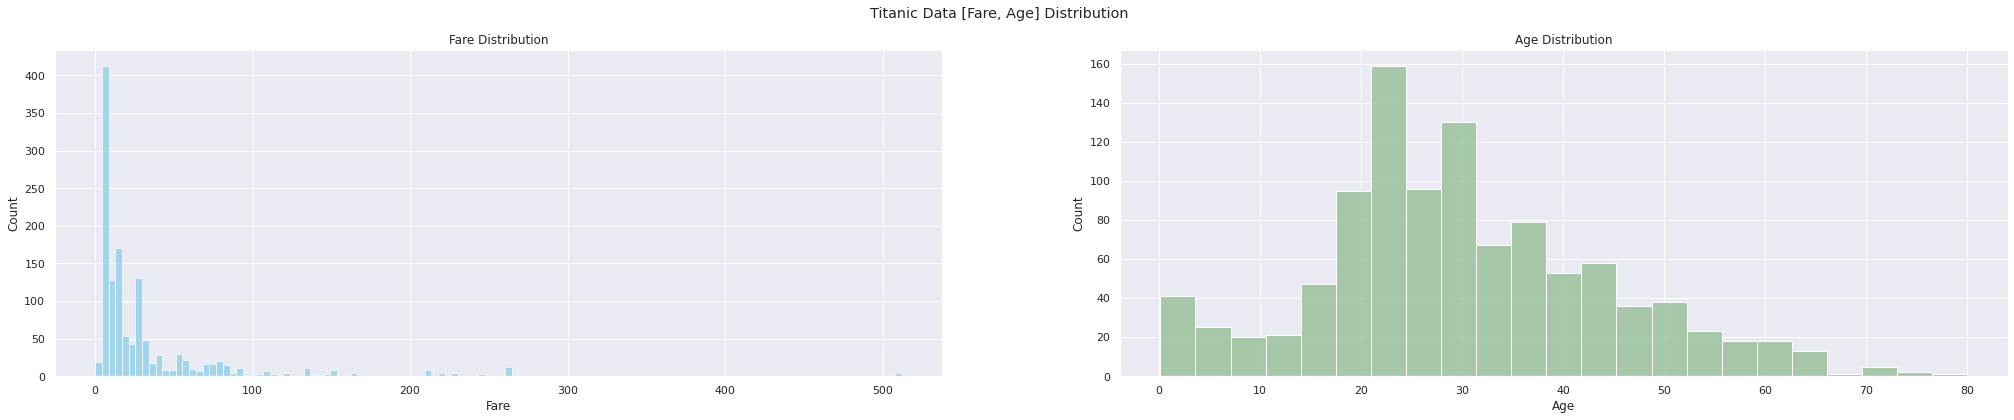

In [ ]:
# Histogram plot numerical attributes of interest 

fig, axs = plt.subplots(1, 2, figsize=(35, 6))

fig.suptitle('Titanic Data [Fare, Age] Distribution')

sns.histplot(data=df, x="Fare", color="skyblue", ax=axs[0])
axs[0].set_title('Fare Distribution')

sns.histplot(data=df, x="Age", color="darkseagreen", ax=axs[1])
axs[1].set_title('Age Distribution')


plt.show()

These distributions tell us that the majority of passengers were aged between 20 and 30 years of age. We may want to look at the survival rate of different age groups later. 

The fare distribution is extremely skewed to the right as well. There may be some data errors given that some passengers paid nearly 250 dollars for a ticket! That's almost 7.5k dollars today!

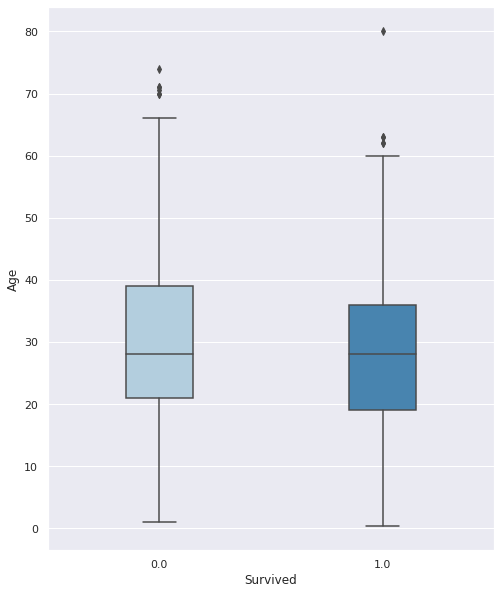

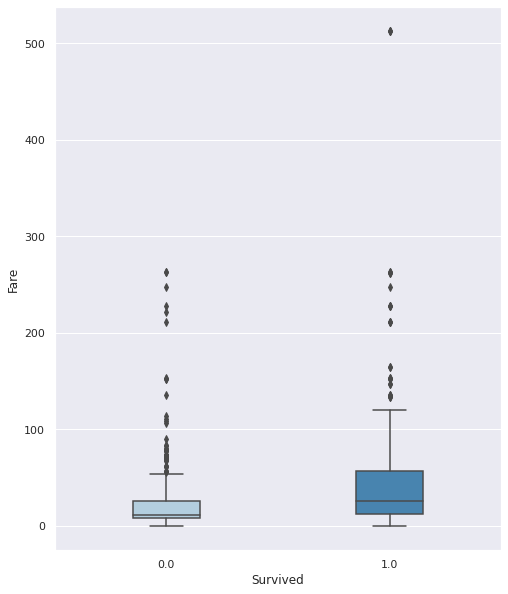

In [ ]:
# Boxplot numerical attributes of interest 

sns.set(rc={'figure.figsize':(8,10)})

sns.boxplot(y=df["Age"], x=df["Survived"], palette="Blues", width=0.3)
plt.show()

sns.boxplot(y=df["Fare"], x=df["Survived"], palette="Blues", width=0.3)
plt.show()

These box plots tell us a lot more about the outliers and errors we observed in the fare distribution. Majority of the ticket priced were below 50 dollars and anything abve 100 dollars is considered an outlier. 

For the age distribution, it seems the distribution of those who survived are slightly younger than those who did not. However, those who did not survive still have a comparable distribution to those who did. 

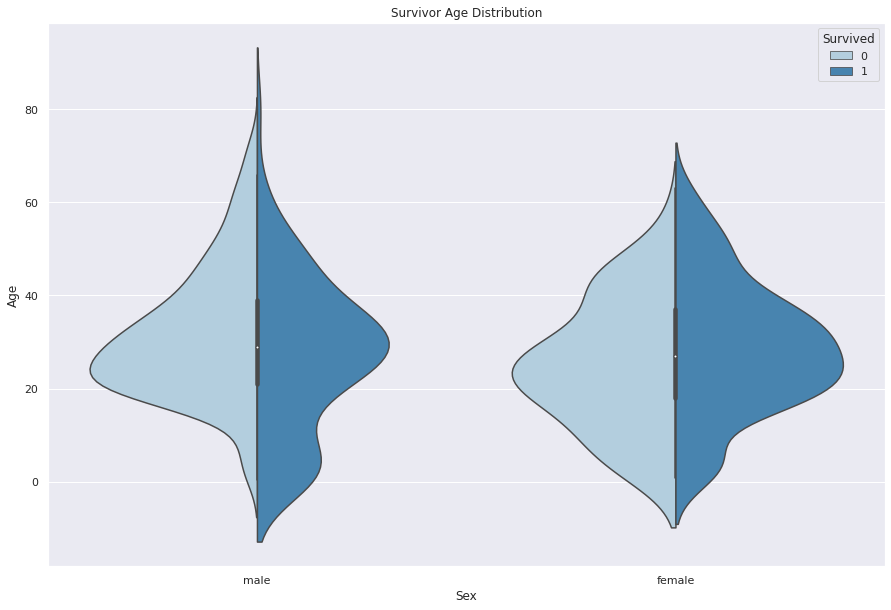

In [ ]:
# Plot the distirbution of female and male passengers who survived and passengers who did not 

plt.figure(figsize=(15,10))
sns.violinplot(x ="Sex", y ="Age", hue ="Survived", data = train, palette="Blues", split = True).set_title('Survivor Age Distribution')
plt.show()

This plot is the most interesting and tells us the most about our privileged and unprivileged groups. It seems that young adult males did not survive as much as young adult females. Younger passengers (male or female) were given the priority of surivial. As Pawar notes as well, these distributions fall into the line of "saving the women and children first" 

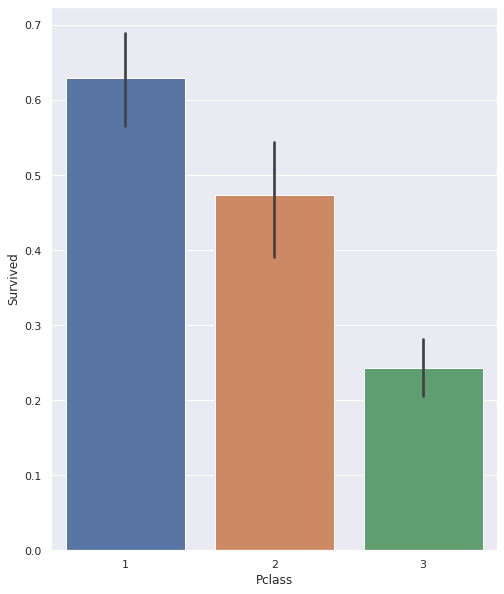

In [ ]:
# Plot the age distirbution of passengers who survived and passengers who did not 
sns.barplot(x = 'Pclass', y = 'Survived', data = train)

This plot shows us the rate of survival for different passenger ticket classes. 1 being the best and 3 being the worst. As it is clear here, those who were in 1st class or 2nd class had a higher rate of surivial than those with 3rd class tickets. 

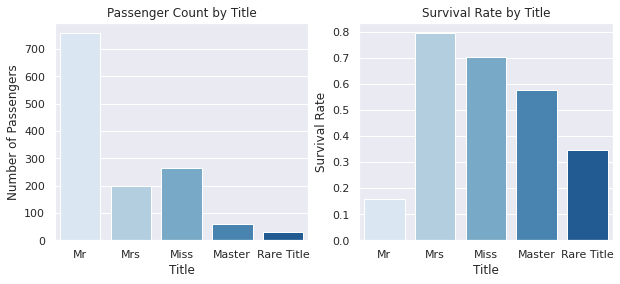

In [ ]:
# Histogram plot of passengers by Title following Pawar's Analysis
a = df.copy()

# Create new column for Title by analyzing Name column
a['Title'] = a['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

a['Title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'}, inplace = True)
a['Title'].replace(['Don','Dona', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer'],'Rare Title', inplace = True)

# Create histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

sns.countplot(x = 'Title', data = a,  ax = ax1, palette="Blues")
ax1.set_title('Passenger Count by Title')
ax1.set_ylabel('Number of Passengers')

# Histogram of Survivors Rate by Title
sns.barplot(x = 'Title', y = 'Survived', data = a, ci = None, ax = ax2, palette="Blues")
ax2.set_title('Survival Rate by Title')
ax2.set_ylabel('Survival Rate');

del a

This visualization was created by Pawar and shows the distribution of surivors given their title. We thought it was interesting to include as a visualization, but we decided not to use titles in our fairness analysis given the number of uncommon/rare titles. However, this does tell us that men (yet again) had the lowest survival rate, even though the greatest number of passengers are men. 

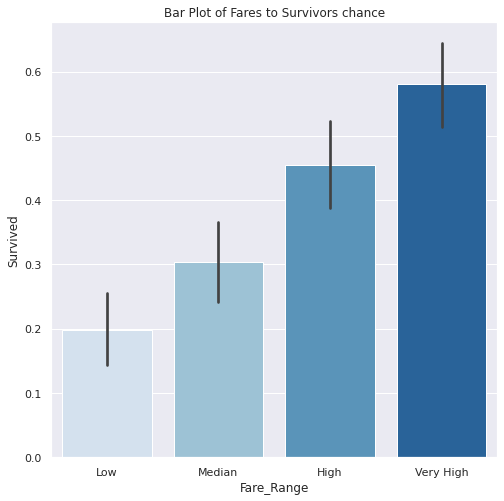

In [ ]:
# Histogram of Survivor proportion to Fare Price following Pawar's Analysis

sns.set(rc={'figure.figsize':(8,8)})
a = df.copy()

# Divide Fare into 4 bins
a['Fare_Range'] = pd.qcut(train['Fare'], 4, labels= ['Low', 'Median', 'High', 'Very High'] )

sns.barplot(x='Fare_Range', y='Survived', data=a, palette="Blues").set_title('Bar Plot of Fares to Survivors chance')

del a

This visualization shows us the distribution of survival given the fare price. Pawar bins these values, and we decided to do the same given the large variation of fare prices and outliers. Here, we decided that when comparing fare bins, those with a low or median fare range were underprivileged while those with high or very high fare ranges were privileged. 

## Correlation Matrix


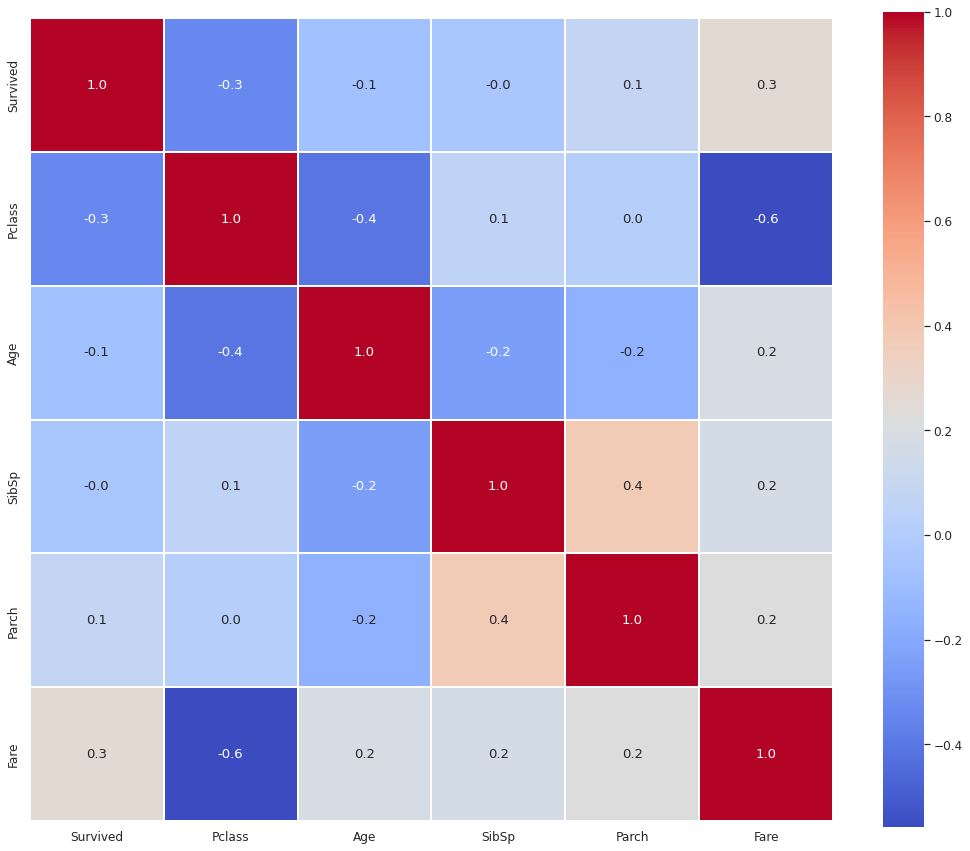

In [ ]:
# Correlational Matrix for Attributes in Dataset following Pawar's Analysis

sns.set(font_scale=1.1)

corr = df.corr()

plt.figure(figsize=(18,15))

sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            fmt='.1f',
            square=True,
            linewidth=1)
plt.show()

From this correlational matrix, we see that surivial has the strongest correlations with Fare and Passenger Class, which we will choose to analyze fairness later

#Adding, Dropping Features of Important following Pawar's ADS

Pawar decides to drop and encode the data in a few ways before training his ADS. To re-create his ADS, we decided to follow his same methods.

In [ ]:
pd.DataFrame.from_dict(
    orient='index',
    columns = ['Attribute','Important','Action'],
    data={
    1: ['PassengerId', 'No', 'Discard'],
    2: ['Sex', 'Yes', 'Encode'],
    3: ['Age', 'Yes', 'Bin and Encode'],
    4: ['Port of Embarkation','No', 'Discard'],
    5: ['Pclass', 'Yes', '-'],
    6: ['Fare', 'Yes', 'Bin and Encode'],
    7: ['SibSp and Parch', 'Yes', 'Engineer "Relatives"'],
    8: ['Name', 'Yes', 'Engineer "Title" and Encode'],
    9: ['Cabin', 'No', 'Discard'],
    10: ['Ticket', 'Yes', 'Engineer "Family_Survival"']})

,Attribute,Important,Action
1,PassengerId,No,Discard
2,Sex,Yes,Encode
3,Age,Yes,Bin and Encode
4,Port of Embarkation,No,Discard
5,Pclass,Yes,-
6,Fare,Yes,Bin and Encode
7,SibSp and Parch,Yes,"Engineer ""Relatives"""
8,Name,Yes,"Engineer ""Title"" and Encode"
9,Cabin,No,Discard
10,Ticket,Yes,"Engineer ""Family_Survival"""


## Encoding 
* Fare_Bin
* Title
* Sex

In [ ]:
# This part of the code is copied from Pawar's Analysis to match the accuracy of his final model
# The code for 'Family_Survival' comes from this kernel:
# https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/notebook

train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')
y = train.Survived

# Merging train data and test data for future feature engineering:
all_data = train.append(test)
all_data.reset_index(inplace=True, drop=True)

all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ',')[0])
all_data['Fare'].fillna(all_data['Fare'].mean(), inplace = True)

default_sr_value = 0.5
all_data['Family_Survival'] = default_sr_value

for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):  # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

for _, grp_df in all_data.groupby('Ticket'):
    
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0
                    
#####################################################################################

all_data['Fare_Bin'] = pd.qcut(all_data['Fare'], 5)
all_data['Relatives'] = all_data['SibSp'] + all_data['Parch']

#####################################################################################

all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'}, inplace = True)
all_data['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                           'Rare Title', inplace = True)    

In [ ]:
for feature in ['Fare_Bin', 'Title', 'Sex']:
    all_data[feature]= all_data[feature].astype('category').cat.codes

## Discard all unnecessary Features

In [ ]:
all_data.drop(['PassengerId', 'Fare', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'Last_Name', 'Embarked'], axis = 1, inplace = True)

print ('Done!')

Done!


## Imputing Age using IterativeImputer

Pawar uses an IterativeImputer to impute null values in the entire dataset (train and test). We decided to allow imputations for "Age" in our own analysis, but use only true values from the train dataset (not use imputed values for Survived). 

The following section will be Pawar's methods to creating his ADS using all imputed values. 

In [ ]:
a = IterativeImputer(random_state=0).fit_transform(all_data)

all_data = pd.DataFrame(a, columns =all_data.columns).convert_dtypes()
del a

#For our own analysis, we made a copy of the dataset before Pawar removes attributes of interest 
analysis_data = all_data.copy()

# Age billing and Encoding
all_data['Age_Bin'] = pd.qcut(all_data['Age'], 5).astype('category').cat.codes

all_data.drop('Age',axis=1, inplace=True)

all_data['Survived'] = all_data['Survived'].astype('int')
analysis_data['Survived'] = analysis_data['Survived'].astype('int')

# Recreating Pawar's Model

The following code is a recreation of Pawar's ADS model using his methods

In [ ]:
# split train test data

train = all_data[:891]

X_train = train.drop('Survived', 1)
y_train = train['Survived'].astype('int')


#######################################################

X_test = all_data[891:]

X_test.drop('Survived', axis = 1, inplace = True)

# Standardize data
std_scaler = StandardScaler()


X_train_scaled = std_scaler.fit_transform(X_train)  # fit_transform the X_train
X_test_scaled = std_scaler.transform(X_test)        # only transform the X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Baseline Models Pawar uses 
The classifiers are:

* Gaussian Naive Bayes ,
* Logistic Regression,
* K-Nearest Neighbor Classifier,
* Support Vector Classifier,
* Decision Tree Classifier,
* Random Forest Classifier,
* Xtreme Gradient Boosting Classifier, and
* AdaBoost classifier.

For the baseline models, Pawar uses their default parameters and evaluate their (mean) accuracy by performing k-fold cross validation.

In [ ]:
def model_check(X, y, estimators, cv=None):
    model_df = pd.DataFrame(columns = ['Model Name', 'Test Accuracy Mean', 'Train Accuracy Mean', 'Test Std', 'Time'])

    for row_index, clf in enumerate(estimators):

        cv_results = cross_validate(
            clf,
            X,
            y,
            cv=cv,
            scoring='accuracy',
            return_train_score=True,
            n_jobs=-1)

        model_df.loc[row_index] = [
            clf.__class__.__name__,
            cv_results['test_score'].mean(),
            cv_results['train_score'].mean(),
            cv_results['test_score'].std(),
            cv_results['fit_time'].mean()]
        
        #model_table.loc[row_index, 'clf Parameters'] = str(clf.get_params())

    model_df.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)
    # Accuracy score DataFrame
    display(model_df.style.background_gradient(cmap='summer_r'))
    
    # accuracy score graph
    sns.barplot('Test Accuracy Mean',
                'Model Name',
                data=model_df,
                orient='h',
                **{'xerr': model_df['Test Std']})
    plt.title('Cross Validation Scores')
    plt.xlim([0.725, 0.88])
    plt.show()

    #return model_df

,Model Name,Test Accuracy Mean,Train Accuracy Mean,Test Std,Time
5,XGBClassifier,0.859714,0.879910,0.009308,0.066144
6,LGBMClassifier,0.858596,0.901234,0.012379,0.048971
2,SVC,0.852947,0.863637,0.019758,0.128820
4,RandomForestClassifier,0.849645,0.914984,0.019549,0.253745
1,KNeighborsClassifier,0.849620,0.879628,0.016303,0.002177
3,DecisionTreeClassifier,0.848522,0.914984,0.017373,0.002932
7,AdaBoostClassifier,0.840657,0.914984,0.019708,0.310034
0,LogisticRegression,0.833902,0.840631,0.010279,0.008855
8,GaussianNB,0.781219,0.797137,0.046138,0.002163


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


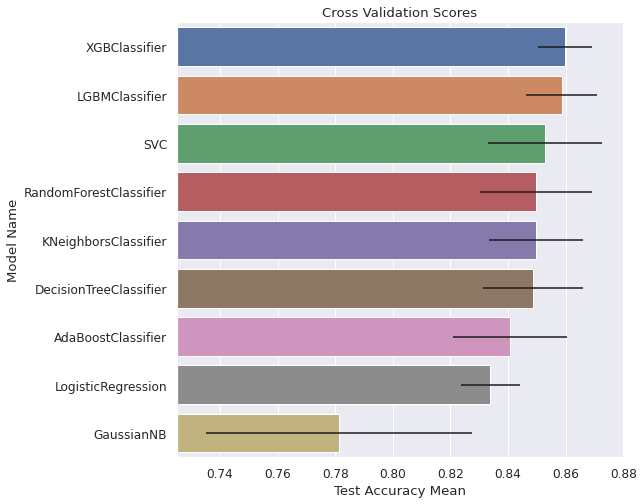

In [ ]:
# Step 1: create a map containing all estimators with their default parameters
clf_list = [
    LogisticRegression(random_state = 1),
    KNeighborsClassifier(), 
    SVC(random_state = 1, probability = True),
    DecisionTreeClassifier(random_state = 1), 
    RandomForestClassifier(random_state = 1),
    XGBClassifier(random_state = 1, use_label_encoder=False),
    LGBMClassifier(),
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state = 1),
    GaussianNB()]

model_check(X=X_train_scaled, y= y_train, estimators= clf_list,cv=5)

According to Pawar, the XGB and LGBM classifiers have the highest accuracy scores. All models score relatively above 80% accuracy as well. 

## Pawar's Voting Classifier ADS

Pawar combines the predictions of all these base classifiers to see if he can get a better predictive performance compared to each constituent individual classifier. This is the main motivation behind Ensemble Learning.

In [ ]:
base_estimators = [(est.__class__.__name__, est) for est in clf_list]

for voting in ['soft', 'hard']:
    
    voting_classifier = VotingClassifier(
        estimators = base_estimators ,
        voting = voting)
    
    cv_results = cross_validate(
        voting_classifier,
        X_train_scaled,
        y_train,
        cv = 5,
        scoring='accuracy',
        return_train_score=True,
        n_jobs=-1)
    
    print(f'\n\n\n\nResult for {voting} VotingClassifier_______\n')
    display(pd.DataFrame(cv_results).mean())





Result for soft VotingClassifier_______



fit_time       0.807862
score_time     0.050425
test_score     0.854121
train_score    0.906005
dtype: float64





Result for hard VotingClassifier_______



fit_time       0.836291
score_time     0.060667
test_score     0.855232
train_score    0.897307
dtype: float64

### Model Tuning

Pawar adjusts each individual model for better accuracy and recreates his voting classifier ADS. 

In [ ]:
model_param = [
    (LogisticRegression(), {'max_iter' : [100],
                            'penalty' : ['l1', 'l2'],
                            'C' : np.logspace(-2, 2, 20),
                            'solver' : ['lbfgs', 'liblinear']}),
    (KNeighborsClassifier(), {'n_neighbors' : np.arange(3, 30, 1),
                              'weights': ['uniform', 'distance'],
                              'algorithm': ['auto'],
                              'p': [1, 2]}),
    (SVC(), [{'kernel': ['rbf'], 
              'gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5],
              'C': [0.1, 0.5,  1, 2, 5]},
              {'kernel': ['linear'], 
              'C': [.1, 1, 2, 10]},
              {'kernel': ['poly'], 
              'degree' : [2, 3, 4, 5], 
              'C': [.1, 1, 10]}]),
    #(DecisionTreeClassifier(random_state = 1), {'max_depth': [3, 5, 10, 20, 50],
    #                                            'criterion': ['entropy', 'gini'],
    #                                            'min_samples_split': [5, 10, 15, 30],
    #                                            'max_features': ['auto', 'sqrt', 'log2']}),
    (RandomForestClassifier(random_state = 42),{'n_estimators': [50, 150, 300, 450],
                                                'criterion': ['entropy'],
                                                'bootstrap': [True],
                                                'max_depth': [3, 5, 10],
                                                'max_features': ['auto','sqrt'],
                                                'min_samples_leaf': [2, 3],
                                                'min_samples_split': [2, 3]}),
    #(XGBClassifier(random_state = 1, use_label_encoder=False,tree_method='gpu_hist', gpu_id=0),{'n_estimators': [15, 25, 50, 100],
    #                                                                                            'colsample_bytree': [0.65, 0.75, 0.80],
    #                                                                                            #'max_depth': [None],
    #                                                                                            'reg_alpha': [1],
    #                                                                                            'reg_lambda': [1, 2, 5],
    #                                                                                            'subsample': [0.50, 0.75, 1.00],
    #                                                                                            'learning_rate': [0.01, 0.1, 0.5],
    #                                                                                            'gamma': [0.5, 1, 2, 5],
    #                                                                                            'min_child_weight': [0.01],
    #                                                                                            'sampling_method': ['uniform']}),
    (LGBMClassifier(random_state=42),{#'num_leaves': sp_randint(6, 50), 
                                      #'min_child_samples': sp_randint(100, 500), 
                                      'min_child_weight': [1e-5, 1e-1, 1, 1e1, 1e2, 1e4],
                                      #'subsample': sp_uniform(loc=0.2, scale=0.8), 
                                      #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                                      'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
                                      'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 10]}),
    (AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1), random_state=1),{'algorithm': ['SAMME', 'SAMME.R'],
                                                                                                    'base_estimator__criterion' : ['gini', 'entropy'],
                                                                                                    'base_estimator__splitter' : ['best', 'random'],
                                                                                                    'n_estimators': [2, 5, 10, 50],
                                                                                                    'learning_rate': [0.01, 0.1, 0.2, 0.3, 1, 2]})]


In [ ]:
def model_tuning_check(X, y, estimators, cv=None):
    model_df = pd.DataFrame(columns = ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score','params','mean_fit_time'])
    best_estimators =[]
    
    for est, param in estimators:

        gscv = GridSearchCV(
            est,
            param_grid= param,
            scoring='accuracy',
            cv=cv,
            #refit=False,
            return_train_score=True,
            n_jobs=-1).fit(X,y)

        model_df.loc[est.__class__.__name__] = pd.DataFrame(
            gscv.cv_results_).loc[
            gscv.best_index_][['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score','params','mean_fit_time']]
        
        #save estimator for later use 
        best_estimators.append(gscv.best_estimator_)
        
    model_df.sort_values(by=['mean_test_score'],
                            ascending=False,
                            inplace=True)
    # Accuracy score DataFrame
    display(model_df.style.background_gradient(cmap='summer_r'))
    
    # accuracy score graph
    sns.barplot('mean_test_score',
                model_df.index,
                data=model_df,
                orient='h',
               **{'xerr': model_df['std_test_score']})
    plt.title('GridSearchCV Scores')
    plt.xlim([0.725, 0.88])
    plt.show()

    return best_estimators

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

,mean_test_score,mean_train_score,std_test_score,std_train_score,params,mean_fit_time
LGBMClassifier,0.867573,0.875982,0.011465,0.002899,"{'min_child_weight': 1e-05, 'reg_alpha': 1, 'reg_lambda': 5}",0.035879
KNeighborsClassifier,0.866449,0.869248,0.009561,0.002568,"{'algorithm': 'auto', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}",0.001998
SVC,0.864196,0.886082,0.004255,0.002751,"{'C': 10, 'degree': 4, 'kernel': 'poly'}",0.044852
RandomForestClassifier,0.861961,0.883278,0.013946,0.002700,"{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}",0.141354
AdaBoostClassifier,0.856387,0.914984,0.021685,0.002242,"{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.2, 'n_estimators': 50}",0.191897
LogisticRegression,0.847360,0.847643,0.004263,0.002291,"{'C': 0.026366508987303583, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.012063


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


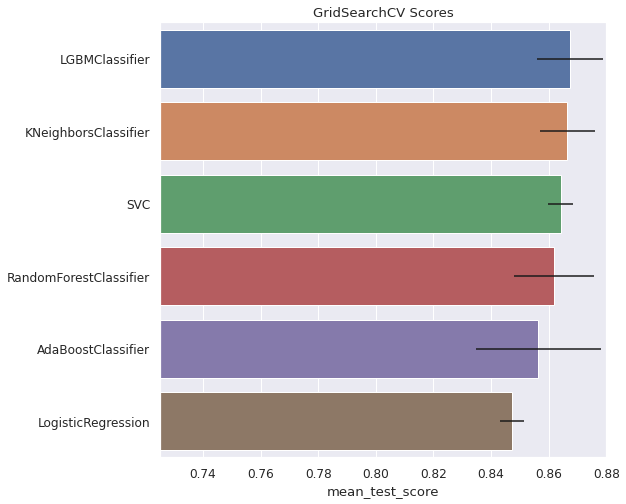

In [ ]:
# This cell may take a while to run, please be patient 
tuned_models= model_tuning_check(X_train_scaled, y_train, estimators= model_param)

In [ ]:
# Pawar's final ADS is a Voting Classifier ensemble designated as "model", we will be using this same model for our analysis
model = VotingClassifier(
    estimators= [(clf.__class__.__name__, clf)  for clf in tuned_models],# if clf.__class__.__name__ not in ['AdaBoostClassifier', 'LogisticRegression']],
    voting='hard')

model.fit(X_train_scaled, y_train)

result = cross_validate(model, 
               X_train_scaled,
               y_train,
               cv = 5,
               scoring='accuracy',
               return_train_score=True,
              n_jobs=-1)
print ('Tuned Voting classifier Models - \n-----------------------')
print (f'Accuracy => {np.round(result["test_score"].mean()*100, 2)} %')

Tuned Voting classifier Models - 
-----------------------
Accuracy => 86.87 %


# Our Analysis on Pawar's ADS

## Re-fitting Pawar's ADS to consider accuracy and disparate impact across groups

In order to analyze the effectiveness (accuracy) of our chosen ADS, we used aif360 to compare performance across different subpopulations: 
* [Female, Male]
* [40 years old or below, Above 40 years old]
* [High/very high fare, lower fares]
* [First and second class, lower classes]. 

For data preparation, we converted all data types to be compatible with aif360, and we converted the variables ‘Age’, ‘Fare_Bin’, and ‘Pclass’ to be binary based on thresholds we set. 

### Re-train Pawar's ADS

As stated before, we decided not to use the imputed "Survival" values in the test.csv like Pawar, so we will split the Age imputed train.csv into train and test dataframes first for our fairness analysis

In [ ]:
# split train test data using the imputed "train.csv" data 

# Fix datatypes in the dataframe:
analysis_data = analysis_data.astype({col: 'int64' for col in analysis_data.select_dtypes('Int64').columns})
analysis_data = analysis_data.astype({col: 'float64' for col in analysis_data.select_dtypes('Float64').columns})

# Recode priviliged groups and unprivileged groups: 
analysis_data['Age'] = np.where((analysis_data['Age']>40), 0, 1) # Those above 40 are underprivileged while those younger are privileged
analysis_data['Fare_Bin'] = np.where(analysis_data['Fare_Bin'] >= 2, 1, 0) # Those with higher fares are privilged
analysis_data['Pclass'] = np.where(analysis_data['Pclass'] > 2, 0, 1) # 1st and 2nd class are privilged 

################################################################################

# Instantiate train dataframes with varying groups of interest to analyze fairness
train = analysis_data[:445]

X_train = train.drop('Survived', 1)
X_train_sex = train.drop(['Survived', "Sex"], 1)
X_train_age = train.drop(['Survived', "Age"], 1)
X_train_fare = train.drop(['Survived', "Fare_Bin"], 1)
X_train_class = train.drop(['Survived', "Pclass"], 1)

y_train = train['Survived'].astype('int')

#######################################################

# Instantiate test dataframes with varying groups of interest to analyze fairness

X_test = analysis_data[445:891]

X_test_sex = X_test.drop(['Survived', "Sex"], axis = 1)
X_test_age = X_test.drop(['Survived', "Age"], axis = 1)
X_test_fare = X_test.drop(['Survived', "Fare_Bin"], axis = 1)
X_test_class = X_test.drop(['Survived', "Pclass"], axis = 1)

Y_test = X_test["Survived"]

X_test_jitter = X_test.drop('Survived', axis = 1)

# Standardize data using StandardScalar 
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train) # fit_transform the X_train
X_test_scaled = std_scaler.fit_transform(X_test_jitter) # only transform the X_test


X_train_scaled_sex = std_scaler.fit_transform(X_train_sex)  
X_test_scaled_sex = std_scaler.transform(X_test_sex)        

X_train_scaled_age = std_scaler.fit_transform(X_train_age)  
X_test_scaled_age = std_scaler.transform(X_test_age)        

X_train_scaled_fare = std_scaler.fit_transform(X_train_fare)  
X_test_scaled_fare = std_scaler.transform(X_test_fare)        

X_train_scaled_class = std_scaler.fit_transform(X_train_class)  
X_test_scaled_class = std_scaler.transform(X_test_class)        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
X_test.sample(15)

,Survived,Pclass,Sex,Age,Family_Survival,Fare_Bin,Relatives
741,0,1,1,1,1.0,1,1
620,0,0,1,1,1.0,1,1
780,1,0,0,1,0.5,0,0
829,1,1,0,0,1.0,1,0
605,0,0,1,1,0.5,1,1
847,0,0,1,1,0.5,0,0
508,0,0,1,1,0.5,1,0
812,0,1,1,1,0.5,0,0
845,0,0,1,0,0.5,0,0
882,0,0,0,1,0.5,1,0


## Fairness Analysis on *Sex* Group: Male (Unprivilged) vs. Female (Privileged) 

In [ ]:
# Method used to tranform dataframe to aif dataset for fairness analysis
def transform_to_aif(df, target, protected_attr):
  '''convert a pandas.DataFrame to a StandardDataset used in AIF360'''

  sd = StandardDataset(
      df,
      label_name = target,
      favorable_classes = [1],
      protected_attribute_names = [protected_attr],
      privileged_classes = [[1]],
      features_to_keep = [target, protected_attr]
  )

  return sd

In [ ]:
# Re_train model for protected value "Sex"

model.fit(X_train_scaled_sex, y_train)

# Make predictions
pred_y = model.predict(X_test_scaled_sex)


In [ ]:
# convert predictions data to AIF StandardDataset

preds_df = X_test.copy()
preds_df['Survived'] = pred_y

sex_preds_aif360 = transform_to_aif(preds_df, 'Survived', 'Sex')


# also create AIF StandardDataset versions of test data

orig_sex_test_aif360 = transform_to_aif(X_test, 'Survived', 'Sex')

In [ ]:
# calculate metrics

privileged_groups = [{'Sex': 0}] 
unprivileged_groups = [{'Sex': 1}]

comparison_metrics = ClassificationMetric(orig_sex_test_aif360, sex_preds_aif360, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

#Accuracy & AUC
accuracy = accuracy_score(Y_test, [pred_prob >= 0.5 for pred_prob in pred_y])
auc = roc_auc_score(Y_test, pred_y)

print("accuracy: ", accuracy)
print("AUC", auc)

print("\nAccuracy for the privileged Group = %f" % comparison_metrics.accuracy(privileged=True))
print("Accuracy for the unprivileged Group = %f" % comparison_metrics.accuracy(privileged=False))

#Disparate Impact
print("\nDisparate Impact = %f" % comparison_metrics.disparate_impact())

#FPR Difference
print("\nFalse positive rate difference = %f" % comparison_metrics.false_positive_rate_difference())

#Precision
print("\nPrecision = %f" % comparison_metrics.precision())

#Statistical Parity Difference
print("\nStatistical Parity Difference = %f" % comparison_metrics.statistical_parity_difference())

accuracy:  0.8094170403587444
AUC 0.7741092840013704

Accuracy for the privileged Group = 0.720280
Accuracy for the unprivileged Group = 0.782178

Disparate Impact = 0.556475

False positive rate difference = 0.144518

Precision = 0.712329

Statistical Parity Difference = -0.207805


## Fairness Analysis on *Age* Group: Old [>40] (Unprivilged) vs. Young [<=40] (Privileged)

In [ ]:
# Re_train model for protected value "Age"

model.fit(X_train_scaled_age, y_train)

# Make predictions
pred_y = model.predict(X_test_scaled_age)



In [ ]:
# convert predictions data to AIF StandardDataset

preds_df = X_test.copy()
preds_df['Survived'] = pred_y

age_preds_aif360 = transform_to_aif(preds_df, 'Survived', 'Age')


# also create AIF StandardDataset versions of test data

orig_age_test_aif360 = transform_to_aif(X_test, 'Survived', 'Age')

In [ ]:
# calculate metrics

privileged_groups = [{'Age': 1}] 
unprivileged_groups = [{'Age': 0}]

comparison_metrics = ClassificationMetric(orig_age_test_aif360, age_preds_aif360, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

#Accuracy & AUC
accuracy = accuracy_score(Y_test, [pred_prob >= 0.5 for pred_prob in pred_y])
auc = roc_auc_score(Y_test, pred_y)

print("accuracy: ", accuracy)
print("AUC", auc)

print("\nAccuracy for the privileged Group = %f" % comparison_metrics.accuracy(privileged=True))
print("Accuracy for the unprivileged Group = %f" % comparison_metrics.accuracy(privileged=False))

#Disparate Impact
print("\nDisparate Impact = %f" % comparison_metrics.disparate_impact())

#FPR Difference
print("\nFalse positive rate difference = %f" % comparison_metrics.false_positive_rate_difference())

#Precision
print("\nPrecision = %f" % comparison_metrics.precision())

#Statistical Parity Difference
print("\nStatistical Parity Difference = %f" % comparison_metrics.statistical_parity_difference())

accuracy:  0.8094170403587444
AUC 0.7741092840013704

Accuracy for the privileged Group = 0.818697
Accuracy for the unprivileged Group = 0.827957

Disparate Impact = 0.859404

False positive rate difference = -0.050885

Precision = 0.838462

Statistical Parity Difference = -0.042219


## Fairness Analysis on *Fare* Group: Low/Median Fare (Unprivileged) vs. High/Very High Fare (Privilged)

In [ ]:
# Re_train model for protected value "Fare"

model.fit(X_train_scaled_fare, y_train)

# Make predictions
pred_y = model.predict(X_test_scaled_fare)


In [ ]:
# convert predictions data to AIF StandardDataset

preds_df = X_test.copy()
preds_df['Survived'] = pred_y

fare_preds_aif360 = transform_to_aif(preds_df, 'Survived', 'Fare_Bin')


# also create AIF StandardDataset versions of test data

orig_fare_test_aif360 = transform_to_aif(X_test, 'Survived', 'Fare_Bin')

In [ ]:
# calculate metrics

privileged_groups = [{'Fare_Bin': 1}] 
unprivileged_groups = [{'Fare_Bin': 0}]

comparison_metrics = ClassificationMetric(orig_fare_test_aif360, fare_preds_aif360, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

#Accuracy & AUC
accuracy = accuracy_score(Y_test, [pred_prob >= 0.5 for pred_prob in pred_y])
auc = roc_auc_score(Y_test, pred_y)

print("accuracy: ", accuracy)
print("AUC", auc)

print("\nAccuracy for the privileged Group = %f" % comparison_metrics.accuracy(privileged=True))
print("Accuracy for the unprivileged Group = %f" % comparison_metrics.accuracy(privileged=False))

#Disparate Impact
print("\nDisparate Impact = %f" % comparison_metrics.disparate_impact())

#FPR Difference
print("\nFalse positive rate difference = %f" % comparison_metrics.false_positive_rate_difference())

#Precision
print("\nPrecision = %f" % comparison_metrics.precision())

#Statistical Parity Difference
print("\nStatistical Parity Difference = %f" % comparison_metrics.statistical_parity_difference())

accuracy:  0.8094170403587444
AUC 0.7741092840013704

Accuracy for the privileged Group = 0.800000
Accuracy for the unprivileged Group = 0.850829

Disparate Impact = 0.404367

False positive rate difference = 0.007353

Precision = 0.828358

Statistical Parity Difference = -0.236005


## Fairness Analysis on *Class* Group: 3rd Class (Unprivileged) vs. 1st/2nd Class (Privileged) 

In [ ]:
# Re_train model for protected value "class"

model.fit(X_train_scaled_class, y_train)

# Make predictions
pred_y = model.predict(X_test_scaled_class)


In [ ]:
# convert predictions data to AIF StandardDataset

preds_df = X_test.copy()
preds_df['Survived'] = pred_y

class_preds_aif360 = transform_to_aif(preds_df, 'Survived', 'Pclass')


# also create AIF StandardDataset versions of test data

orig_class_test_aif360 = transform_to_aif(X_test, 'Survived', 'Pclass')

In [ ]:
# calculate metrics

privileged_groups = [{'Pclass': 1}] 
unprivileged_groups = [{'Pclass': 0}]

comparison_metrics = ClassificationMetric(orig_class_test_aif360, class_preds_aif360, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

#Accuracy & AUC
accuracy = accuracy_score(Y_test, [pred_prob >= 0.5 for pred_prob in pred_y])
auc = roc_auc_score(Y_test, pred_y)

print("accuracy: ", accuracy)
print("AUC", auc)

print("\nAccuracy for the privileged Group = %f" % comparison_metrics.accuracy(privileged=True))
print("Accuracy for the unprivileged Group = %f" % comparison_metrics.accuracy(privileged=False))

#Disparate Impact
print("\nDisparate Impact = %f" % comparison_metrics.disparate_impact())

#FPR Difference
print("\nFalse positive rate difference = %f" % comparison_metrics.false_positive_rate_difference())

#Precision
print("\nPrecision = %f" % comparison_metrics.precision())

#PStatistical Parity Difference
print("\nStatistical Parity Difference = %f" % comparison_metrics.statistical_parity_difference())

accuracy:  0.8094170403587444
AUC 0.7741092840013704

Accuracy for the privileged Group = 0.766990
Accuracy for the unprivileged Group = 0.845833

Disparate Impact = 0.475703

False positive rate difference = 0.034441

Precision = 0.821705

Statistical Parity Difference = -0.211246


## Robustness Test with Jitter

To test whether the ADS is robust to changes, we will add some noise to the test data. When we alter the magnitude of the noise, we can infer how well the model will perform with new data and different sources of noise.

In this example we’re going to add some random, normally-distributed noise. 

Below a jitter_test runs a prediction on the new jitter data over several different jitter scales (standard deviations). To make the resulting curves a little smoother, we’re performing the experiment several times and taking the average. This code was sourced [here](https://winder.ai/testing-model-robustness-with-jitter/). 

In [ ]:
def jitter(X, scale=0.1):
    return X + np.random.normal(0, scale, X.shape)

def jitter_test(classifier, X, y, scales = np.linspace(0, 1, 40), N = 10):
    out = []
    for s in scales:
        avg = 0.0
        for r in range(N):
            avg += metrics.accuracy_score(y, classifier.predict(jitter(X, s)))
        out.append(avg / N)
    return out, scales

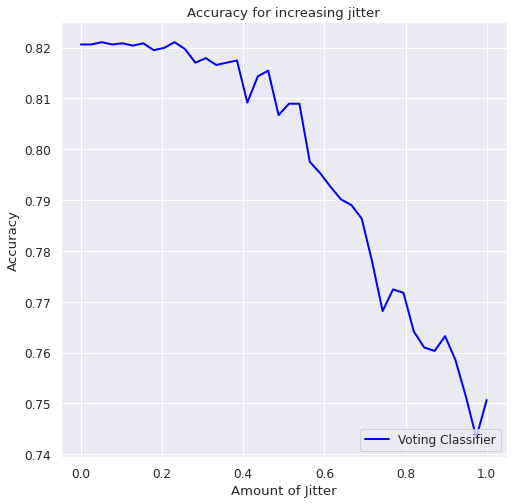

In [ ]:
model.fit(X_train_scaled,y_train);

mdl2_scores, jitters = jitter_test(model, X_test_scaled, Y_test)

plt.figure()

lw = 2

plt.plot(jitters, mdl2_scores, color='blue',
         lw=lw, label='Voting Classifier')

plt.xlabel('Amount of Jitter')
plt.ylabel('Accuracy')
plt.title('Accuracy for increasing jitter')
plt.legend(loc="lower right")
plt.show()